In [ ]:
from utils import *
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
patient = 'S001'

high_pass = 8.0
low_pass = 12.0

filepath_open = f'../../data/eegmmidb (raw)/files/{patient}/{patient}R01.edf'
raw_open = get_raw(filepath_open, filter=True, high_pass=high_pass, low_pass=low_pass)
psd_open = raw_open.compute_psd()

filepath_closed = f'../../data/eegmmidb (raw)/files/{patient}/{patient}R02.edf'
raw_closed = get_raw(filepath_closed, filter=True, high_pass=high_pass, low_pass=low_pass)
psd_closed = raw_closed.compute_psd()

In [ ]:
psd_open.plot();
plt.show()
psd_closed.plot();
plt.show()

In [10]:
raw_open.info['ch_names']

['FC5',
 'FC3',
 'FC1',
 'FCz',
 'FC2',
 'FC4',
 'FC6',
 'C5',
 'C3',
 'C1',
 'Cz',
 'C2',
 'C4',
 'C6',
 'CP5',
 'CP3',
 'CP1',
 'CPz',
 'CP2',
 'CP4',
 'CP6',
 'Fp1',
 'Fpz',
 'Fp2',
 'AF7',
 'AF3',
 'AFz',
 'AF4',
 'AF8',
 'F7',
 'F5',
 'F3',
 'F1',
 'Fz',
 'F2',
 'F4',
 'F6',
 'F8',
 'FT7',
 'FT8',
 'T7',
 'T8',
 'T9',
 'T10',
 'TP7',
 'TP8',
 'P7',
 'P5',
 'P3',
 'P1',
 'Pz',
 'P2',
 'P4',
 'P6',
 'P8',
 'PO7',
 'PO3',
 'POz',
 'PO4',
 'PO8',
 'O1',
 'Oz',
 'O2',
 'Iz']

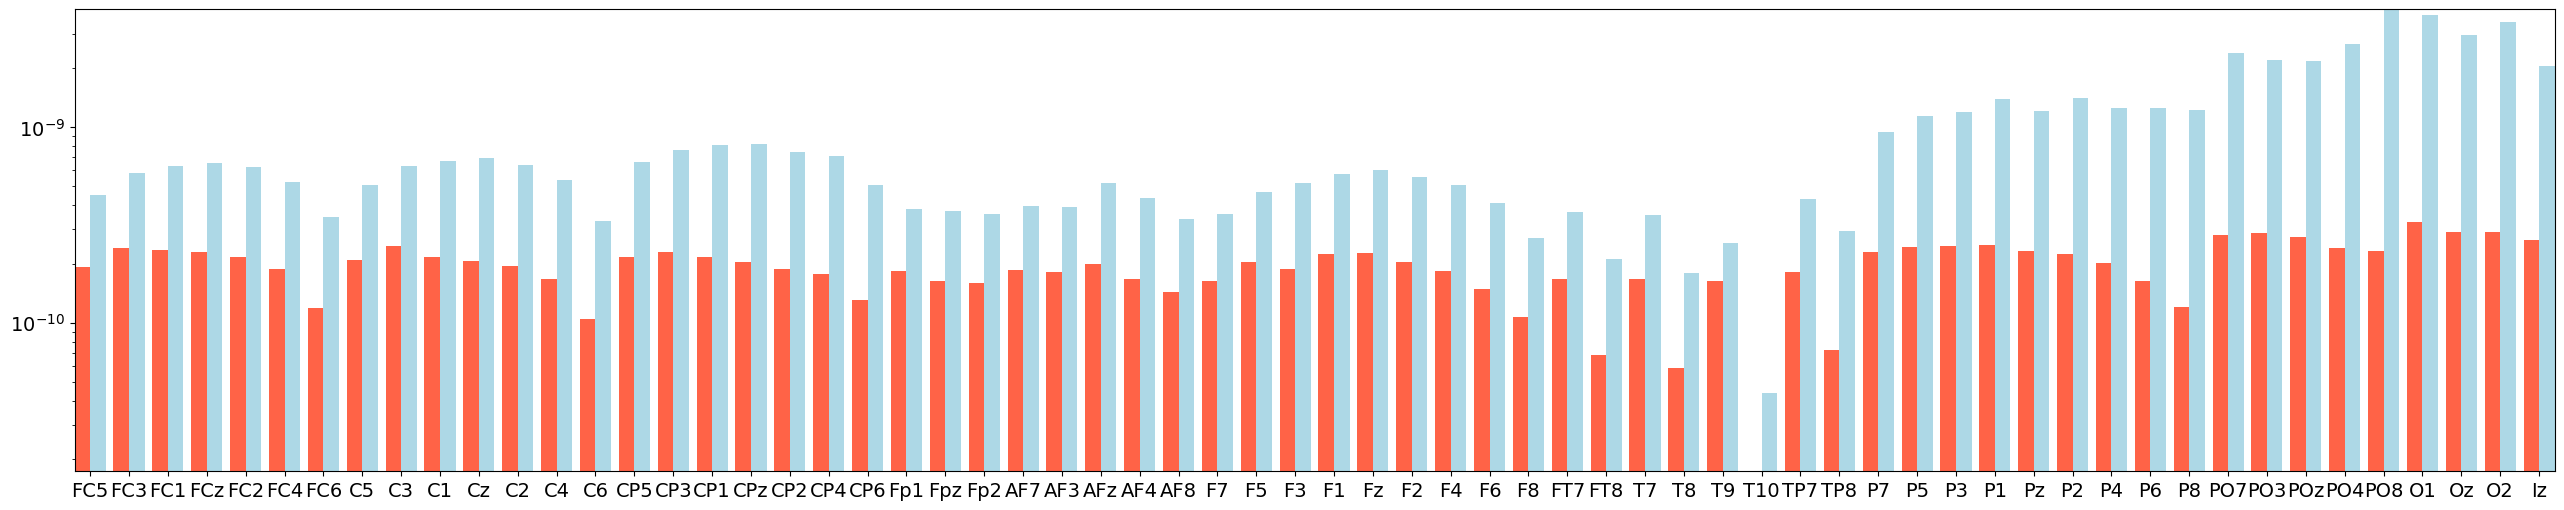

In [53]:
fig, ax = plt.subplots(1, 1, figsize=(32, 6))

bar_width = 0.4

open_color = 'tomato'
closed_color = 'lightblue'

x = np.arange(64)
ax.bar(x-bar_width/2, (raw_open.get_data()**2).mean(axis=1), color=open_color, width=bar_width)
ax.bar(x+bar_width/2, (raw_closed.get_data()**2).mean(axis=1), color=closed_color, width=bar_width)

ax.set_yscale('log')
ax.margins(0)

ax.set_xticks(x, raw_open.info['ch_names'], fontsize=14)
ax.tick_params(axis='y', which='major', labelsize=14)
plt.show()

In [18]:
occipital_idx = [raw_open.info['ch_names'].index(channel) for channel in ['O1', 'Oz', 'O2']]
(raw_open.get_data()[occipital_idx]**2).mean()

3.021083826697278e-10

In [19]:
(raw_closed.get_data()[occipital_idx]**2).mean()

3.3790147361847745e-09

In [ ]:
# sort dict by keys
def sort_dict(dict):
    return {k: dict[k] for k in sorted(dict.keys())}

DATA_PATH = '/home/williamtheodor/Documents/DL for EEG Classification/data/'
PARCELLATION = 'aparc.a2009s'
#PARCELLATION = 'HCPMMP1_combined'
PARCELLATION_PATH = DATA_PATH + 'mmidb_' + PARCELLATION + '/mmidb_'+ PARCELLATION

alpha_activity = np.load(PARCELLATION_PATH + '_1.0_8.0_12.0_parallel.npy', allow_pickle=True).item()

data = {
    'Alpha': sort_dict(alpha_activity),
}

In [ ]:
activity_open_sanity.keys()

In [ ]:
open_sanity = activity_open_sanity['T0'][0]
closed_sanity = activity_closed_sanity['T0'][0]
total_sanity = open_sanity + closed_sanity

patient = 'S001'
open_calculated = data['Alpha'][patient][patient+'R01']['T0'][0]
closed_calculated = data['Alpha'][patient][patient+'R02']['T0'][0]
total_calculated = open_calculated + closed_calculated

In [ ]:
 # Label sizes
TICK_LABEL_SIZE = 18
AXIS_LABEL_SIZE = 24
TITLE_LABEL_SIZE = 32

# set width of bar
barWidth = 0.4

# make plot
fig, axes = plt.subplots(2, 1, figsize=(32, 12), sharey=True)

# Set position of bar on X axis
X = np.arange(activity_open_sanity['T0'].shape[1])
br1 = [x - barWidth/2 for x in X]
br2 = [x + barWidth/2 for x in X]

left_color = 'tomato'
right_color = 'lightblue'



# Make the plot
axes[0].bar(br1, open_sanity/total_sanity, color=left_color, width = barWidth,
        edgecolor ='grey', label ='OPEN')
axes[0].bar(br2, closed_sanity/total_sanity, color=right_color, width = barWidth,
        edgecolor ='grey', label ='CLOSED')
axes[0].set_title('Sanity Check', fontsize=TITLE_LABEL_SIZE)

axes[1].bar(br1, open_calculated/total_calculated, color=left_color, width = barWidth,
        edgecolor ='grey', label ='OPEN')
axes[1].bar(br2, closed_calculated/total_calculated, color=right_color, width = barWidth,
        edgecolor ='grey', label ='CLOSED')
axes[1].set_title('Calculated', fontsize=TITLE_LABEL_SIZE)


for ax in axes:
        # Adding ticks
        ax.set_xlabel('Regions', fontsize=AXIS_LABEL_SIZE)
        ax.set_ylabel('Proportional Activity', fontsize=AXIS_LABEL_SIZE)
        #ax.set_xticks(X, label_names, fontsize=TICK_LABEL_SIZE, rotation=90)
        ax.margins(.01)
        ax.tick_params(axis='y', which='major', labelsize=TICK_LABEL_SIZE)



plt.tight_layout() 
plt.legend(fontsize=TICK_LABEL_SIZE)

plt.show()